# Demo for equiPy

## What its all about
A short demonstration on how to use _equipy_ on a set of real data.

Here, we use data derived from the US census using the [folktables](https://github.com/socialfoundations/folktables) package, freely available. Our goal is to render predictions of log income fair, with respect to demographic parity. 

We fit a very simple gradient boosting machine on the data and then compare:
* Fairness and performance of the optimal (unfair) predictor $f^*$ vs the fair estimator wrt. _race_
* Fairness and performance of $f^*$ vs the fair estimator wrt. _race_ **and** _gender_

## Prerequisits

This demo environment has the following packages installed:

1. equipy
2. lightgbm (for fitting)
3. folktables (to load the data set)
4. seaborn (for the kde plots)

Other dependencies should be covered in internal dependencies of _equipy_

You will also need to set your working directory below. 

## Suggestions and Comments

Feel free to share your thoughts and ideas to one of the authors 

In [1]:
# Change this to your local repository
work_dir = '/Users/philippratz/Documents/Uni/PhD/UQAM/pkgs/equipy_demo'

In [2]:
import os 
os.chdir(work_dir)

In [ ]:
# Some manipulations for the illustration
import numpy as np
import pandas as pd

# For the basemodel
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from utils.dataloader import load_sunbelt_data
from utils.preprocessing import preprocess_census
from utils.evaluation import cv_early_stopping

In [5]:
# Load some benchmarking data, can be replaced by any
# other data set
#
# Here we only load data for california and texas
# both large states but with differing economies
data_all = load_sunbelt_data(states=['CA', 'TX'])

In [6]:
data_all.shape

(329338, 11)

In [7]:
cat_features = ['OCCP', 'POBP', 'SCHL', 'RELP']

ret_dict =  preprocess_census(data=data_all,
                              target_feature='PINCP',
                              sensitive_features=['SEX', 'RAC1P_black'],
                              categorical_features=cat_features,
                              continuous_features=['WKHP', 'AGEP'])

In [8]:
params = {
    "objective": "regression",
    "metric": "mse",
    "min_data_in_leaf": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "verbose": -1
}

In [9]:
%%capture
cv_results = cv_early_stopping(params=params, 
                               nfolds=5, 
                               max_rounds=1000, 
                               early_stopping_rounds=20, 
                               X_train=ret_dict['X_train'], 
                               y_train=ret_dict['y_train'], 
                               categorical_feats=cat_features)

In [10]:
best_res = np.argmin(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

print((f"Best MSE: {np.min(cv_results['metric'])} \nBest Iter: {best_iter}"))

Best MSE: 0.5453194561305283 
Best Iter: 630


In [11]:
# Retrain whole model
data_train_all = lgb.Dataset(data=ret_dict['X_train'], 
                             label=ret_dict['y_train'], 
                             categorical_feature=cat_features)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)

In [12]:
predictions = best_estimator.predict(ret_dict['X_test'])
pred_1 = predictions[np.where(ret_dict['X_test'].RAC1P_black == 1)[0]]
pred_2 = predictions[np.where(ret_dict['X_test'].RAC1P_black == 0)[0]]

<Axes: ylabel='Density'>

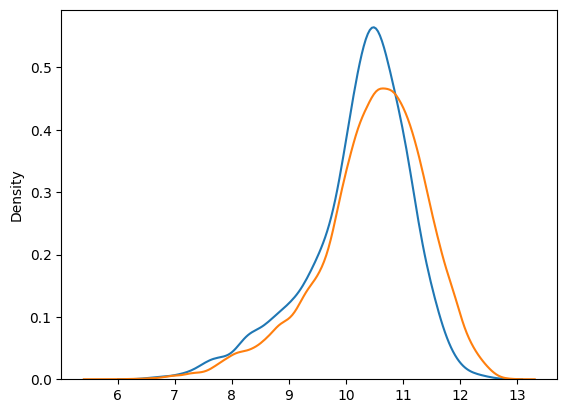

In [13]:
sns.kdeplot(pred_1)
sns.kdeplot(pred_2)

# Usage of Equipy

Here, we demonstrate how the _equipy_ package can be used to mitigate the unfairness in the predictions. 

In general, _equipy_ follows the logic of scikit-learn, where the mitigation method is a class that is first instantiated and then `fit()`-ted on training data to be used in the `tranform()` step on the test-set. 

See also the documentation for both 
* [FairWasserstein](https://equilibration.github.io/equipy/equipy.fairness.html#equipy.fairness.FairWasserstein)
* [unfairness](https://equilibration.github.io/equipy/equipy.metrics.html#equipy.metrics.unfairness)

In [14]:
from equipy.fairness._wasserstein import FairWasserstein
from equipy.metrics import unfairness

In [15]:
## Univariate case

In [16]:
predictions_train = best_estimator.predict(ret_dict['X_train'])
sensitive_train = np.where(ret_dict['X_train'].RAC1P_black == 1, 1, 0)

In [17]:
predictions_unfair = predictions_train.copy()
sensitive_feat = np.where(ret_dict['X_test'].RAC1P_black == 1, 1, 0)

calibrator = FairWasserstein(sigma=0.001)
calibrator.fit(predictions_unfair, sensitive_train)
fair_predictions = calibrator.transform(predictions, sensitive_feat)

In [18]:
pred_1_fair = fair_predictions[np.where(ret_dict['X_test'].RAC1P_black == 1)[0]]
pred_2_fair = fair_predictions[np.where(ret_dict['X_test'].RAC1P_black == 0)[0]]

<Axes: ylabel='Density'>

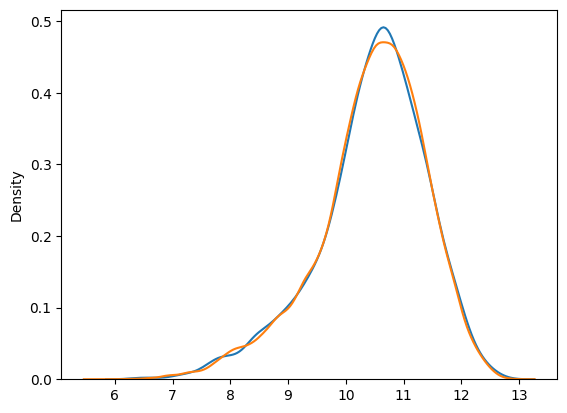

In [19]:
sns.kdeplot(pred_1_fair)
sns.kdeplot(pred_2_fair)

In [20]:
mean_squared_error(ret_dict['y_test'], predictions)

0.546978288858531

In [21]:
mean_squared_error(ret_dict['y_test'], fair_predictions)

0.5514062010266904

In [22]:
unfairness(predictions, sensitive_feat)

0.39180104326248255

In [23]:
unfairness(fair_predictions, sensitive_feat)

0.0671277087638078

## Two-Variable case

In the case where we have two sensitive variables, the simple approach via a single barycenter is insufficient. The class `MultiWasserstein` contains an automated fitting routine that deals with the situation where the sensitive variable is not a vector but a matrix. 

In [42]:
from equipy.fairness import MultiWasserstein

In [43]:
sensitive_train_twovar = np.concatenate([np.where(ret_dict['X_train'].SEX_2 == 1, 1, 0).reshape(-1,1),
                                         np.where(ret_dict['X_train'].RAC1P_black == 1, 1, 0).reshape(-1,1)],
                                         axis=1)

In [44]:
sensitive_feat_twovar = np.concatenate([np.where(ret_dict['X_test'].SEX_2 == 1, 1, 0).reshape(-1,1),
                                         np.where(ret_dict['X_test'].RAC1P_black == 1, 1, 0).reshape(-1,1)],
                                         axis=1)


In [45]:
unfairness(predictions, sensitive_feat_twovar)

0.39180104326248255

In [46]:
unfairness(fair_predictions, sensitive_feat_twovar)

0.28732637596817234

In [47]:
intersectional_groups = np.apply_along_axis(lambda d: str(d[0]) + '-' + str(d[1]), 1, sensitive_feat_twovar)

viz_frame = pd.DataFrame({
    'scores': predictions, 
    'fair_scores_race': fair_predictions, 
    'sensitive_race': sensitive_feat, 
    'sensitive_sex': np.where(ret_dict['X_test'].SEX_2 == 1, 1, 0), 
    'intersectional_groups': intersectional_groups
    })

viz_frame.head()

,scores,fair_scores_race,sensitive_race,sensitive_sex,intersectional_groups
0,8.519385,8.504838,0,0,0-0
1,10.520185,10.507865,0,0,0-0
2,9.379906,9.365025,0,0,0-0
3,10.839585,10.824342,0,1,1-0
4,11.288112,11.268385,0,1,1-0


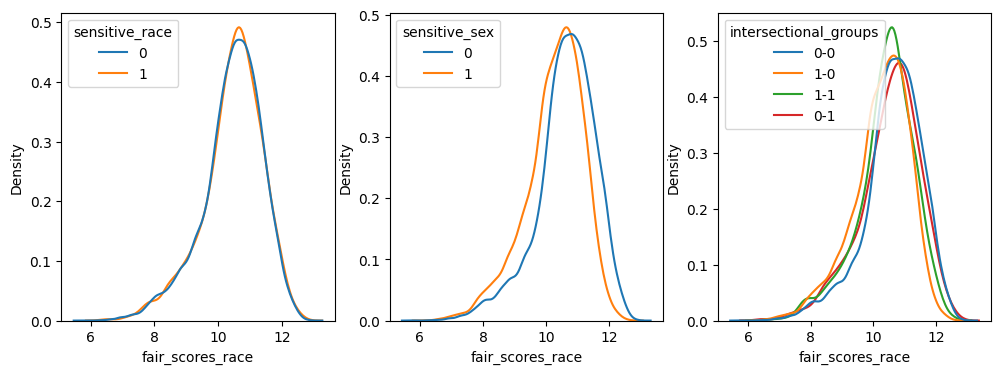

In [48]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

sns.kdeplot(data=viz_frame, 
            x='fair_scores_race',
            hue='sensitive_race',
            common_norm=False,
            ax=ax[0])

sns.kdeplot(data=viz_frame, 
            x='fair_scores_race',
            hue='sensitive_sex',
            common_norm=False,
            ax=ax[1])

sns.kdeplot(data=viz_frame, 
            x='fair_scores_race',
            hue='intersectional_groups',
            common_norm=False,
            ax=ax[2]);

Visually, the scores seem to be particularly biased towards women of color

In [49]:
# run correction on two 
calibrator_multi = MultiWasserstein(sigma=0.01)
calibrator_multi.fit(predictions_train, sensitive_train_twovar)
fair_predictions_twovar = calibrator_multi.transform(predictions, sensitive_feat_twovar)

In [50]:
unfairness(predictions, sensitive_feat_twovar)

0.39180104326248255

In [51]:
unfairness(fair_predictions_twovar, sensitive_feat_twovar)

0.05140000676161449

In [52]:
viz_frame_mitig = pd.DataFrame({
    'scores': predictions, 
    'fair_scores_race': fair_predictions, 
    'fair_scores_both': fair_predictions_twovar,
    'sensitive_race': sensitive_feat, 
    'sensitive_sex': np.where(ret_dict['X_test'].SEX_2 == 1, 1, 0), 
    'intersectional_groups': intersectional_groups
    })

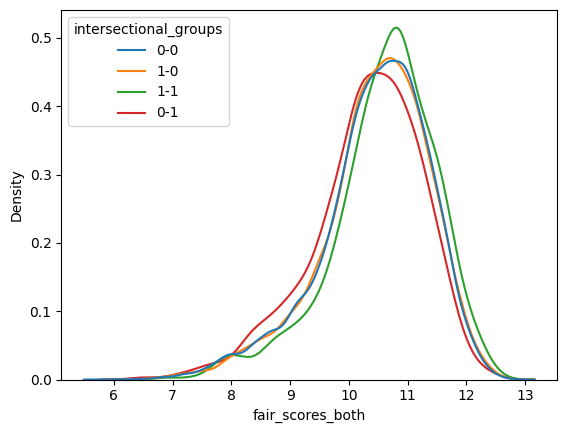

In [54]:
sns.kdeplot(data=viz_frame_mitig, 
            x='fair_scores_both',
            hue='intersectional_groups',
            common_norm=False);

There appears to be still some way to go to achieve complete fairness. This would need to be addressed separately in a tuning step of both the model and the calibrator. 

However, globally the predictions are a lot more equal, even with a simple procedure. 